# E(n)-Equivariant Steerable CNNs  -  Hands-on tutorial

## Preliminaries

We start by importing the necessary packages. The user typically only needs to interact with the high level functionalities provided in the subpackages `escnn.gspaces` and `escnn.nn`.

In [1]:
import torch
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from escnn import gspaces
from escnn import nn

import numpy as np
np.set_printoptions(precision=3, linewidth=10000, suppress=True)

Parse the dataset info for the gabor dataset that is being used as example: 

In [2]:
def read_gabor_data(path):
    df = pd.read_csv(path)
    return df

c8_z2_5_path = os.path.join('C:\\Users\\oat\\Datasets\\gabor_data\\C8_Z2_5')
c8_path = os.path.join('C:\\Users\\oat\\Datasets\\gabor_data\\C8')

Read the path for the example image(s). Note that the variable naming corresponds to image_input_orientation_shiftx_shifty. So for example, an image with the gabor path not rotated, not translated in any axis is:

In [3]:
gabor_data = read_gabor_data(c8_z2_5_path+'/description.csv')
example_input_0_0_0 = gabor_data[(gabor_data['orientation_0'] == 0.0) & (gabor_data['shift_x_0'] == 0) & (gabor_data['shift_y_0'] == 0)]
image_input_0_0_0_path = os.path.join(c8_z2_5_path, example_input_0_0_0['image_name'].values[0])
print(image_input_0_0_0_path)

C:\Users\oat\Datasets\gabor_data\C8_Z2_5\gabor1_000000.png


In [61]:
def plot_img(img, title='img'):
    height, width = img.shape[:2]

    plt.imshow(img, cmap='gray', origin='upper', interpolation='nearest')
    plt.grid(True, color="gray", linestyle="--", linewidth=0.5)

    # Set tick positions at pixel corners
    plt.xticks(np.arange(width+1)-.5, labels=np.arange(width+1))
    plt.yticks(np.arange(height+1)-0.5, labels=np.arange(height+1))
    plt.gca().xaxis.set_ticks_position('top')

    plt.title(title)

    plt.gcf().set_size_inches(2, 2)

    plt.show()

def plot_multiple_3d_tensors(tensors, titles=None, cmap="viridis", alpha=0.6, aspect_ratio=[1, 1, 1], fig_size = (8, 8)):
    """
    Plot multiple 3D tensors side by side.
    
    :param tensors: List of 3D tensors (each of shape (1, C, H, W))
    :param titles: List of titles corresponding to each tensor
    :param cmap: Colormap to use for coloring
    :param alpha: Transparency of the voxels
    :param aspect_ratio: Aspect ratio for the voxel plots
    """

    num_tensors = len(tensors)
    fig, axes = plt.subplots(1, num_tensors, figsize=(8 * num_tensors, 8), subplot_kw={'projection': '3d'})

    if titles is None:
        titles = [f"Tensor {i+1}" for i in range(num_tensors)]  # Default titles

    for i, (tensor, ax) in enumerate(zip(tensors, np.atleast_1d(axes))):
        tensor = tensor.squeeze(0).detach().numpy()  # Remove batch dimension if exists

        # Normalize tensor values for color mapping
        normalized_tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)

        # Assign colors from a colormap
        cmap_obj = plt.get_cmap(cmap)
        colors = cmap_obj(normalized_tensor)  # Shape (C, H, W, 4)

        # Add transparency (alpha)
        colors[..., 3] = alpha  

        # Create voxel grid
        voxels = np.ones(tensor.shape, dtype=bool)  # Shape (C, H, W)

        # Plot voxels with assigned colors and transparency
        ax.voxels(voxels.transpose(0, 2, 1), facecolors=colors.transpose(0, 2, 1, 3), edgecolor='k', alpha=alpha)

       
        ax.set_box_aspect(aspect_ratio)  

        # Adjust limits to align with grid
        ax.set_xlim([0, tensor.shape[0]])  # Channels (C)
        ax.set_ylim([0, tensor.shape[1]])  # Width (W)
        ax.set_zlim([0, tensor.shape[2]])  # Height (H)

        # Set axis ticks to only integer numbers
        ax.set_xticks(np.arange(0, tensor.shape[0]+1, 1))
        ax.set_yticks(np.arange(0, tensor.shape[1]+1, 1))
        ax.set_zticks(np.arange(0, tensor.shape[2]+1, 1))

        # Labels
        ax.set_xlabel('Channels (C) - Feature Maps')
        ax.set_ylabel('Width (W) - Image Columns')
        ax.set_zlabel('Height (H) - Image Rows')

        # Title
        ax.set_title(titles[i])

    fig.set_size_inches(fig_size[0] * num_tensors, fig_size[1])

    # Show the plot
    plt.show()


## Input
A grayscale image as input defines a signal on the plane $\mathbb{R}^2$:

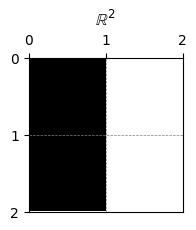

In [5]:
# Load the image
img = mpimg.imread(image_input_0_0_0_path)
plot_img(img, title=r'$\mathbb{R}^2$')


# Symmetry space
We determine both the **point group** and its **action on the space** by instantiating a subclass of `gspace.GSpace`.
For the rotational action of $G=C_4$ on $\mathbb{R}^2$ this is done by:

In [6]:
r2_c4_act = gspaces.rot2dOnR2(N=4)
r2_c4_act

C4_on_R2[(None, 4)]

This indicates that the base space is $\mathbb{R}^2$, and that the symmetry transformation to model is that of the cyclic subgroup  $C_4$, which models the $4$ *rotations* which are multiples of $\frac{\pi}{2}$, that is, $\big\{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\big\}$. Because these are perfect symmetries of the grid, transforming an image with this group does not require any interpolation.

In contrast to that, regular CNNs model symmetry transformations corresponding to discrete translations (i.e. shifts). To follow the same thinking process as with the C4 example, with escnn we can also instantiate a subclass of gspace.GSpace for the shift action in R2, here defined as a trivial action:

In [7]:
r2_shift_act = gspaces.trivialOnR2()
r2_shift_act

C1_on_R2[(None, 1)]

In this case, the base space is $\mathbb{R}^2$ with cyclic subgroup  $C_1$,

## Signals

### in
Formally, we consider the input to be a signal. 
We need to define how the signals transform under the group action G (in this case G=C4).
This depends on the type of field that the feature fields from the input define.

The simplest example is a grayscale image.A rotation of a gray-scale image is performed by moving each pixel to a new position without changing their intensity values. That means, a gray-scale image is a **scalar field**.


In [8]:
feat_type_in_c4 = nn.FieldType(r2_c4_act, [r2_c4_act.trivial_repr])
feat_type_in_c4

[C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)]

In [9]:
feat_type_in_shift = nn.FieldType(r2_shift_act, [r2_shift_act.trivial_repr])
feat_type_in_shift

[C1_on_R2[(None, 1)]: {irrep_0 (x1)}(1)]

### out
Instead of scalar feature fields, we often choose so called **regular feature fields** $f:\mathbb{R}^2\to\mathbb{R}^{|G|}$ in the hidden layers of the model.
Regular feature fields associate a feature vector of dimensionality equal to the cardinality of $G$, in our case $|C_4|=4$, to each point.

In [10]:
feat_type_out_c4 = nn.FieldType(r2_c4_act, [r2_c4_act.regular_repr])
feat_type_out_c4

[C4_on_R2[(None, 4)]: {regular (x1)}(4)]

In [11]:
feat_type_out_shift = nn.FieldType(r2_shift_act, [r2_shift_act.regular_repr])
feat_type_out_shift

[C1_on_R2[(None, 1)]: {regular (x1)}(1)]

As deep feature spaces typically comprise multiple independent features (equal to channels for conventional CNNs), we usually choose multiple feature fields.
For example, we can use 3 regular fields.
The full feature space is in this case modeled as a *stacked* field $f: \mathbb{R}^2 \to \mathbb{R}^{3|G|}$ which transforms according to the **direct sum** of three regular representations:

$$\rho(\theta)
    \ =\ \rho_\text{reg}(\theta) \oplus \rho_\text{reg}(\theta) \oplus \rho_\text{reg}(\theta)
    \ =\ \begin{bmatrix} 
            \rho_\text{reg}(\theta) & 0 & 0 \\
            0 & \rho_\text{reg}(\theta) & 0 \\
            0 & 0 & \rho_\text{reg}(\theta) \\
          \end{bmatrix}
          \quad\in\ \mathbb{R}^{3N \times 3N}$$

Intuitively, the direct sum simply builds a block diagonal representation of the three regular representations, which implies that the three regular fields transform independently from each other.

We instantiate a `nn.FieldType` composed of 3 regular representations by passing the full field representation as a list of three regular representations:

In [12]:
feat_type_out_c4 = nn.FieldType(r2_c4_act, 3*[r2_c4_act.regular_repr])
feat_type_out_c4

[C4_on_R2[(None, 4)]: {regular (x3)}(12)]

In [13]:
feat_type_out_shift = nn.FieldType(r2_shift_act, 3*[r2_shift_act.regular_repr])
feat_type_out_shift

[C1_on_R2[(None, 1)]: {regular (x3)}(3)]

## Equivariant modules

Once having defined how the input and output feature spaces should transform, we can build neural network functions as **equivariant modules**.
These are implemented as subclasses of an abstract base class `nn.EquivariantModule` which itself inherits from `torch.nn.Module`.

We start by instantiating a convolutional layer that maps between fields of types `feat_type_in` and `feat_type_out`:

In [14]:
c4_conv = nn.R2Conv(feat_type_in_c4, feat_type_out_c4, kernel_size=1)
c4_conv

R2Conv([C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)], [C4_on_R2[(None, 4)]: {regular (x3)}(12)], kernel_size=1, stride=1)

In [15]:
shift_conv = nn.R2Conv(feat_type_in_shift, feat_type_out_shift, kernel_size=1)
shift_conv

R2Conv([C1_on_R2[(None, 1)]: {irrep_0 (x1)}(1)], [C1_on_R2[(None, 1)]: {regular (x3)}(3)], kernel_size=1, stride=1)

Each equivariant module has an input and output type.
As a function (`.forward()`), it *requires* its inputs to transform according to its input type and is guaranteed to return feature fields associated with its output type.
To prevent the user from accidentally feeding an incorrectly transforming input field into an equivariant module, we perform a dynamic type checking.
In order to do so, we define **geometric tensors** as data containers.
They are wrapping a *PyTorch* `torch.Tensor` to augment them with an instance of `FieldType`.

Let's build a few random 32x32 gray-scale images and wrap them into an `nn.GeometricTensor`:

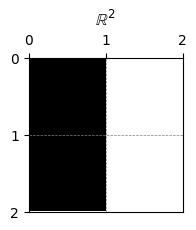

In [16]:
img = mpimg.imread(image_input_0_0_0_path)
plot_img(img, title=r'$\mathbb{R}^2$')
# Convert the image to a torch tensor
# Note that shape must be BCHW (batch, channel, height, width)
img_tensor = torch.tensor(img, dtype=torch.float).unsqueeze(0).unsqueeze(0)


In [17]:
x_c4 = feat_type_in_c4(img_tensor)
print(x_c4)
print(x_c4.tensor)

x_shift = feat_type_in_shift(img_tensor)
print(x_shift)
print(x_shift.tensor)

g_tensor([[[[0., 1.],
            [0., 1.]]]], [C4_on_R2[(None, 4)]: {irrep_0 (x1)}(1)])
tensor([[[[0., 1.],
          [0., 1.]]]])
g_tensor([[[[0., 1.],
            [0., 1.]]]], [C1_on_R2[(None, 1)]: {irrep_0 (x1)}(1)])
tensor([[[[0., 1.],
          [0., 1.]]]])


As usually done in *PyTorch*, an image or feature map is stored in a 4-dimensional array of shape BxCxHxW, where B is the batch-size, C is the number of channels and W and H are the spatial dimensions.

We can feed a geometric tensor to an equivariant module as we feed normal tensors in *PyTorch*'s modules:

In [18]:
y_c4 = c4_conv(x_c4)
print(y_c4.tensor.shape)

y_shift = shift_conv(x_shift)
print(y_shift.tensor.shape)

torch.Size([1, 12, 2, 2])
torch.Size([1, 3, 2, 2])


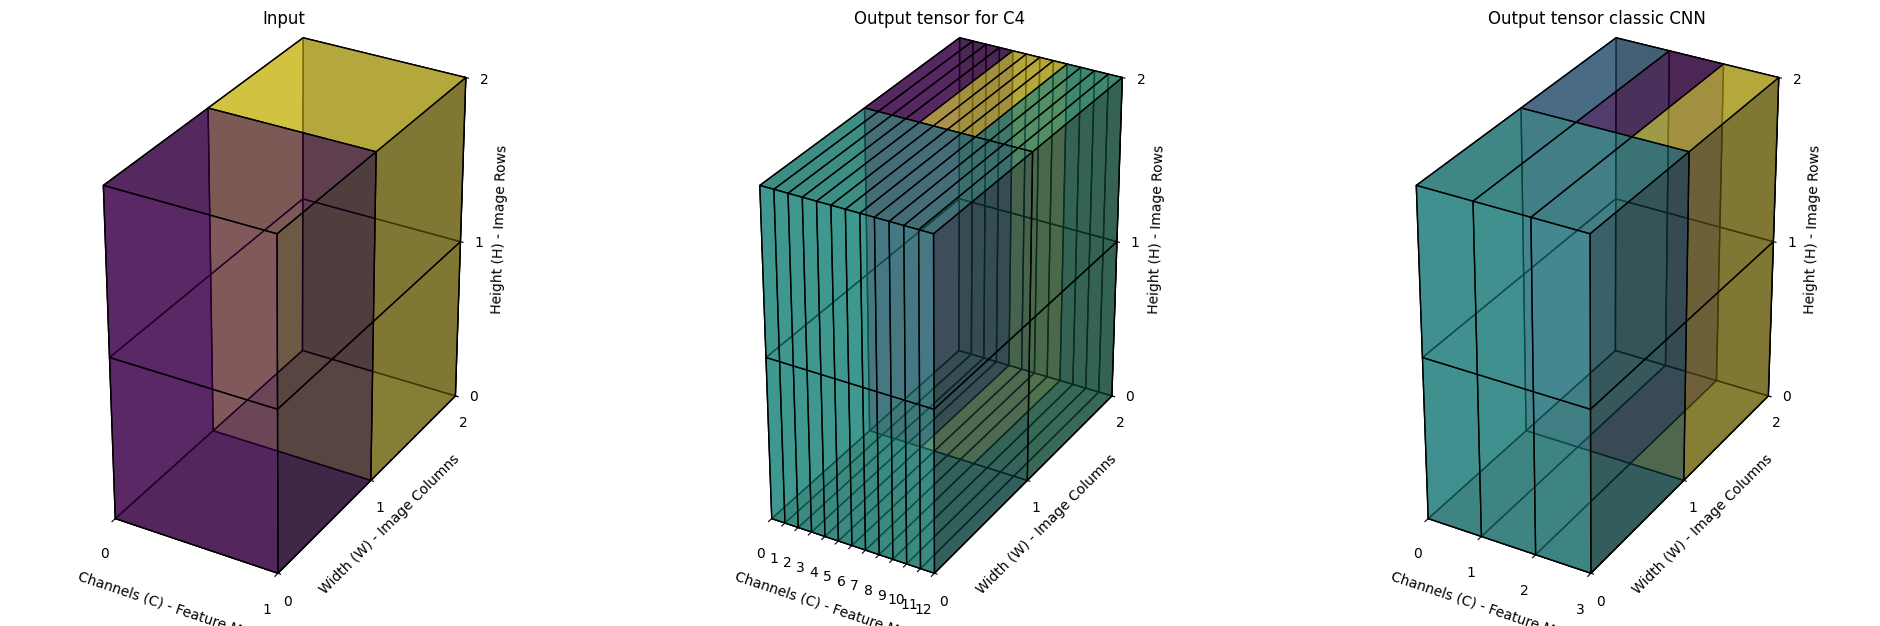

In [58]:
# Plot the 3D tensor
plot_multiple_3d_tensors([img_tensor.unsqueeze(0).squeeze(0), y_c4.tensor, y_shift.tensor], aspect_ratio=[1, 2, 2], titles=["Input", "Output tensor for C4", "Output tensor classic CNN"])


Lets check whether the output transforms as described by the output type when the input transforms according to the input type.
The $G$-transformation of a geometric tensor is hereby conveniently done by calling `nn.GeometricTensor.transform()`.

0[2pi/4]


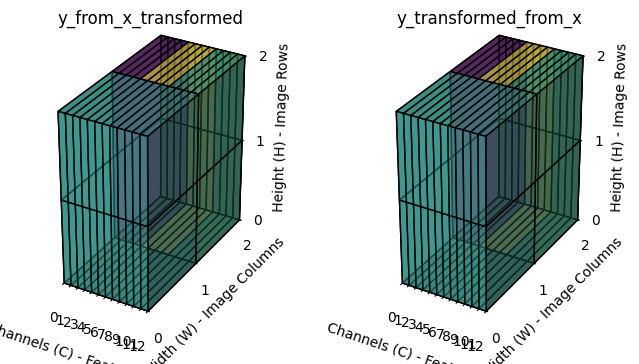

1[2pi/4]


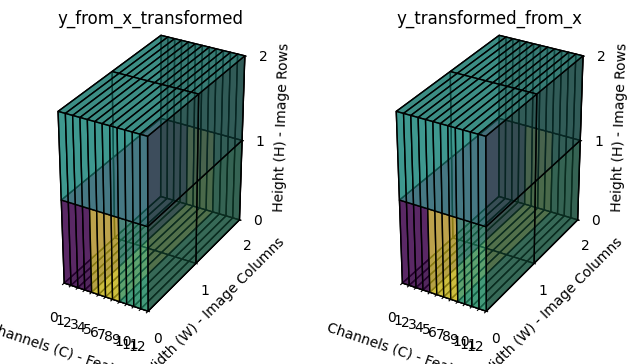

2[2pi/4]


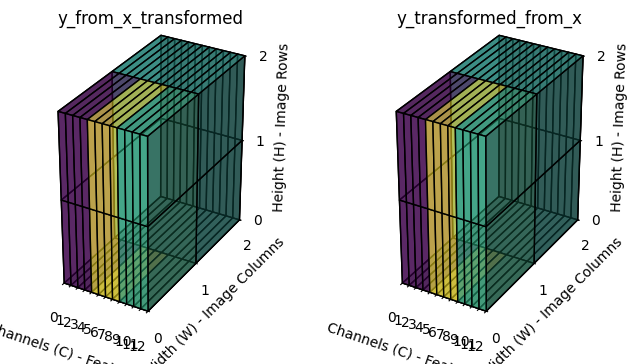

3[2pi/4]


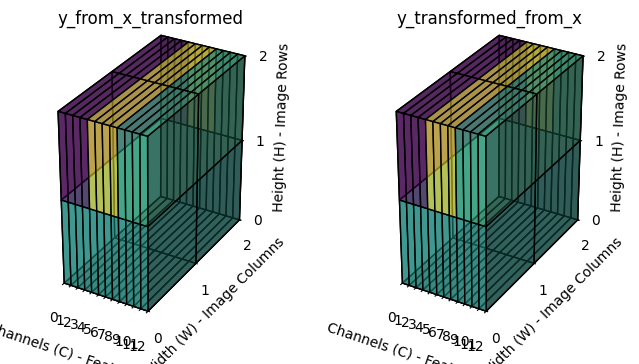

In [63]:
# for each group element
for g in r2_c4_act.testing_elements:
    print(g)
    # transform the input with the current group element according to the input type
    x_transformed = x_c4.transform(g)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = c4_conv(x_transformed)
    
    # the result should be equivalent to rotating the output produced in the 
    # previous block according to the output type
    y_transformed_from_x = y_c4.transform(g)

    plot_multiple_3d_tensors([y_from_x_transformed.tensor,y_transformed_from_x.tensor], aspect_ratio=[1, 2, 2], titles=["y_from_x_transformed", "y_transformed_from_x"], fig_size=(4,4) )

    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

45
tensor([[[[0., 1.],
          [0., 1.]]]])


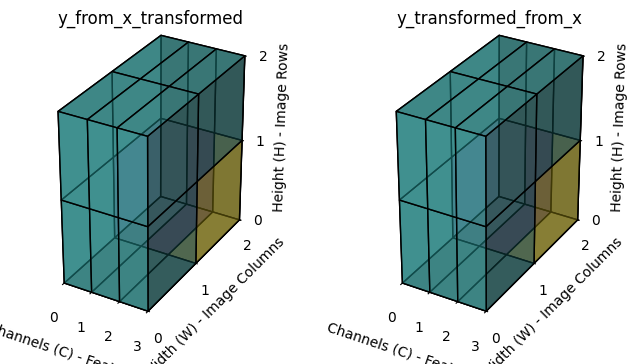

90
tensor([[[[0., 1.],
          [0., 1.]]]])


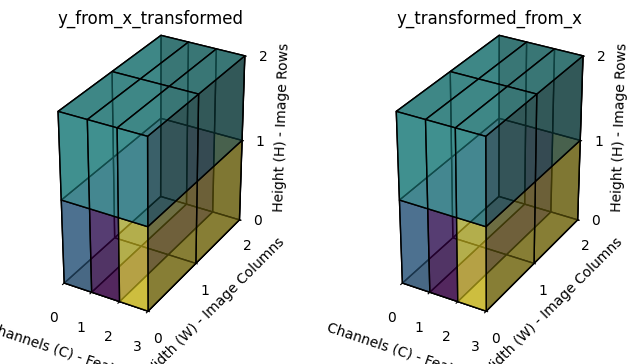

180
tensor([[[[0., 1.],
          [0., 1.]]]])


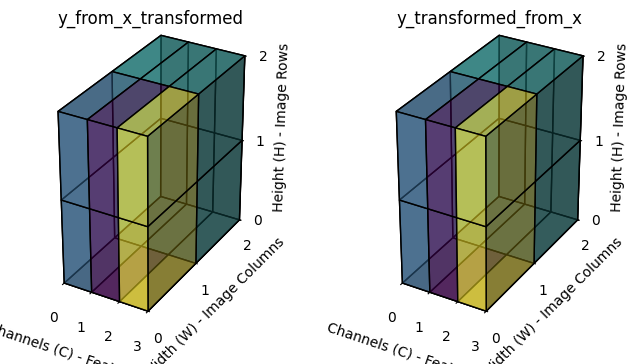

270
tensor([[[[0., 1.],
          [0., 1.]]]])


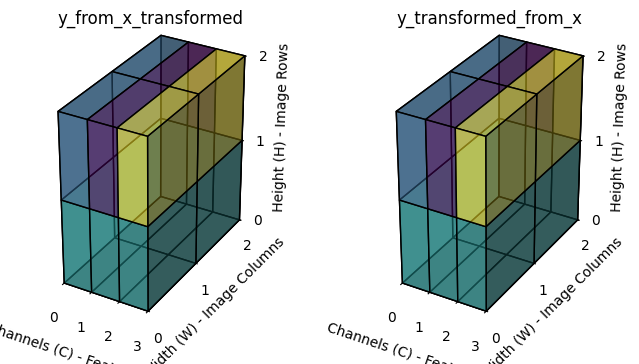

In [80]:
import torchvision
# for each group element
for g in [45,90,180,270]:
    print(g)
    # transform the input with the current group element according to the input type
    print(torch.Tensor(x_shift.tensor))
    x_transformed = torchvision.transforms.functional.rotate(x_shift.tensor, g)
    
    # feed the transformed input in the convolutional layer
    y_from_x_transformed = shift_conv(feat_type_in_shift(x_transformed))
    
    # the result should be equivalent to rotating the output produced in the 
    # previous block according to the output type
    y_transformed_from_x = torchvision.transforms.functional.rotate(y_shift.tensor, g)

    plot_multiple_3d_tensors([y_from_x_transformed.tensor,y_transformed_from_x], aspect_ratio=[1, 2, 2], titles=["y_from_x_transformed", "y_transformed_from_x"], fig_size=(4,4) )

Any network operation is required to be equivariant.
`escnn.nn` provides a wide range of equivariant network modules which guarantee this behavior.

As an example, we will next apply an **equivariant nonlinearity** to the output feature field of the convolution.
For the specific case of regular representations, any pointwise nonlinearity like *ReLUs* are equivariant.
Note that this is *not* the case for many other choices of representations / field types!

We instantiate a `escnn.nn.ReLU`, which, as an `nn.EquivariantModule`, requires to be informed about its input type to be able to perform the type checking.
Here we are passing `feat_type_out`, the output of the equivariant convolution layer, as input type.
It is not necessary to pass an output type to the nonlinearity since this is here determined by its input type.

In [92]:
relu_c4 = nn.ReLU(feat_type_out_c4)
z_c4 = relu_c4(y_c4)

We can verify the equivariance again:

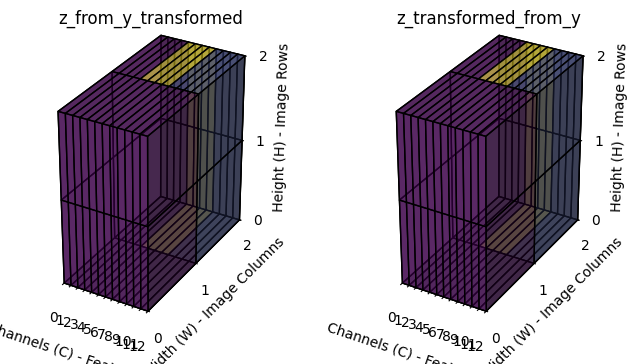

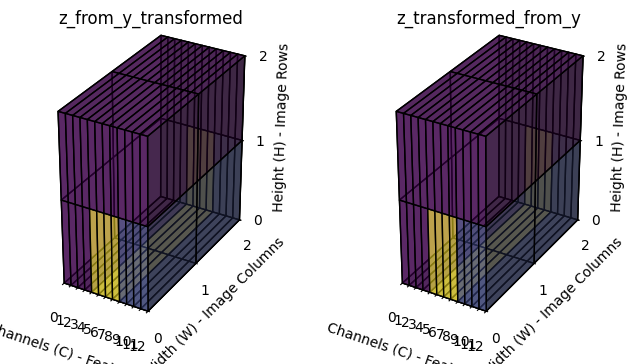

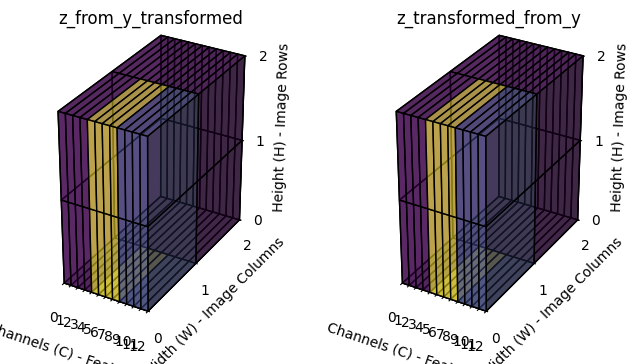

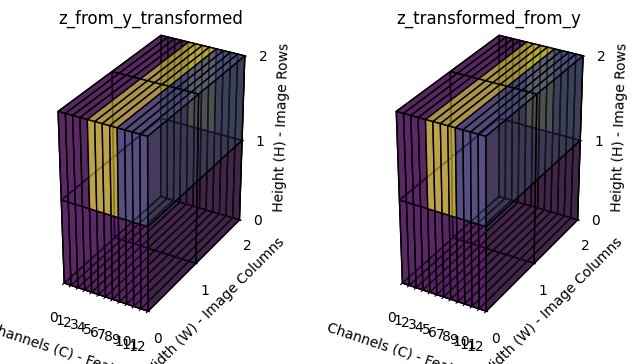

In [93]:
# for each group element
for g in r2_c4_act.testing_elements:
    y_transformed = y_c4.transform(g)
    z_from_y_transformed = relu_c4(y_transformed)
    
    z_transformed_from_y = z_c4.transform(g)
    plot_multiple_3d_tensors([z_from_y_transformed.tensor,z_transformed_from_y.tensor], aspect_ratio=[1, 2, 2], titles=["z_from_y_transformed", "z_transformed_from_y"], fig_size=(4,4) )
    assert torch.allclose(z_from_y_transformed.tensor, z_transformed_from_y.tensor, atol=1e-5), g

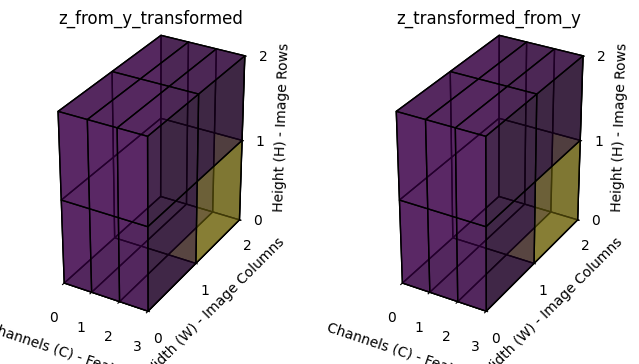

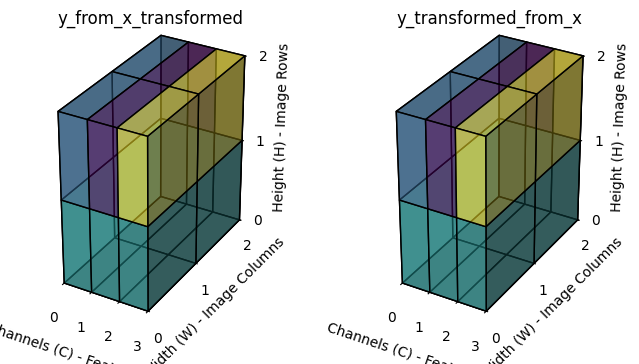

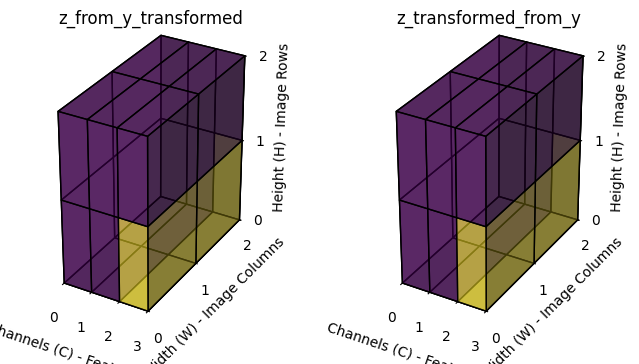

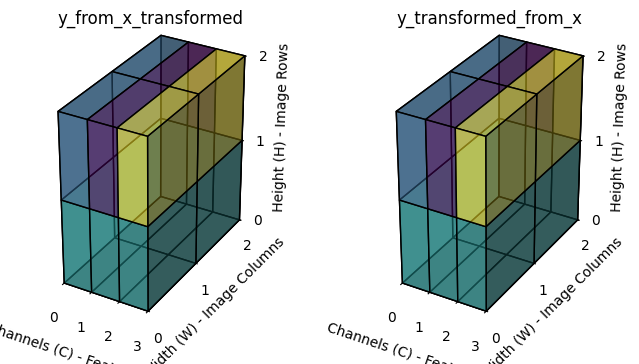

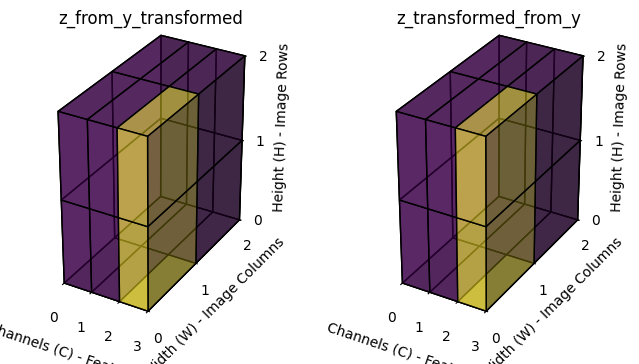

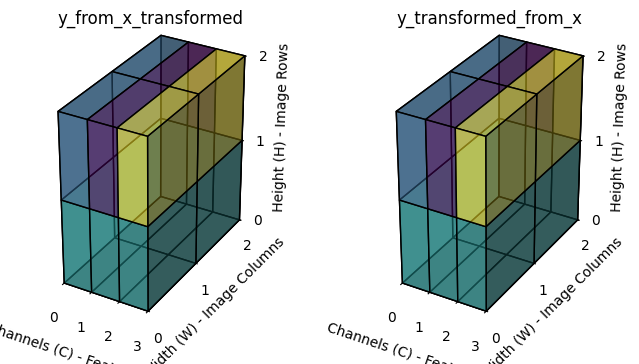

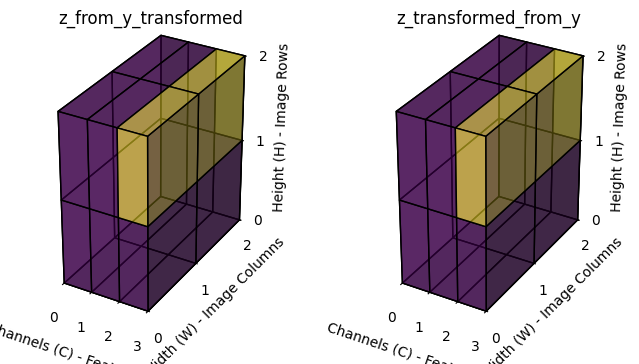

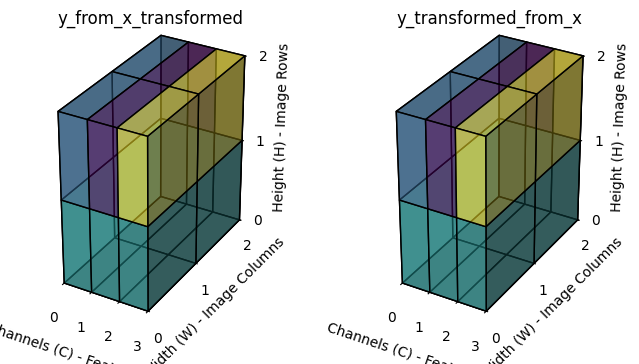

In [97]:
relu_shift = nn.ReLU(feat_type_out_shift)
z_shift = relu_shift(y_shift)

# for each group element
for g in [45,90,180,270]:
    y_transformed = torchvision.transforms.functional.rotate(y_shift.tensor, g)
    z_from_y_transformed = relu_shift(feat_type_out_shift(y_transformed))
    
    z_transformed_from_y = torchvision.transforms.functional.rotate(z_shift.tensor, g)
    plot_multiple_3d_tensors([z_from_y_transformed.tensor,z_transformed_from_y], aspect_ratio=[1, 2, 2], titles=["z_from_y_transformed", "z_transformed_from_y"], fig_size=(4,4) )
    assert torch.allclose(z_from_y_transformed.tensor, z_transformed_from_y, atol=1e-5), g

    plot_multiple_3d_tensors([y_from_x_transformed.tensor,y_transformed_from_x], aspect_ratio=[1, 2, 2], titles=["y_from_x_transformed", "y_transformed_from_x"], fig_size=(4,4) )

In *deep learning* we usually want to stack multiple layers to build a deep model.
As long as each layer is equivariant and consecutive layers are compatible, the equivariance property is preserved by induction.

The compatibility of two consecutive layers requires the output type of the first layer to be equal to the input type of the second layer.

In case we feed an input with the wrong type to a module, an error is raised:

Simple deeper architectures can be built using a **SequentialModule**:

In [ ]:
feat_type_in = nn.FieldType(r2_c4_act, [r2_c4_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_c4_act, 8*[r2_c4_act.regular_repr])
feat_type_out = nn.FieldType(r2_c4_act, 2*[r2_c4_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()


As every layer is equivariant and consecutive layers are compatible, the whole model is equivariant.

In [ ]:
x = torch.randn(1, 1, 17, 17)
x = feat_type_in(x)

y = model(x)

# for each group element
for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = model(x_transformed)
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

Usually, at the end of the model we want to produce a single feature vector to use for classification.
To do so, it is common to pool over the spatial dimensions, e.g. through average pooling.

This produces (approximately) translation-invariant feature vectors.

In [ ]:
avgpool = nn.PointwiseAvgPool(feat_type_out, 11)

y = avgpool(model(x))

print(y.shape)

torch.Size([1, 8, 1, 1])


In our case, the feature vectors $f(x)\in\mathbb{R}^c$ associated to each point $x\in\mathbb{R}^2$ have a well defined transformation law.
The output of the model now transforms according to `feat_type_out` (here two $C_4$ regular fields, i.e. 8 channels).
For our choice of regular representations (which are permutation representations) the channels in the feature vectors associated to each point permute when the input is rotated.

In [ ]:
for i in range(4):
    g = r2_act.fibergroup.element(i)
    print(f'rotation by {i}*pi/2:', y.transform(g).tensor[0, ...].detach().numpy().squeeze())

rotation by 0*pi/2: [ 0.509  0.465  0.455  0.525 -0.009  0.006 -0.037  0.019]
rotation by 1*pi/2: [ 0.525  0.509  0.465  0.455  0.019 -0.009  0.006 -0.037]
rotation by 2*pi/2: [ 0.455  0.525  0.509  0.465 -0.037  0.019 -0.009  0.006]
rotation by 3*pi/2: [ 0.465  0.455  0.525  0.509  0.006 -0.037  0.019 -0.009]


Many learning tasks require to build models which are **invariant** under rotations.
We can compute invariant features from the output of the model using an **invariant map**.
For instance, we can take the maximum value within each regular field.
We do so using `nn.GroupPooling`:

In [ ]:
invariant_map = nn.GroupPooling(feat_type_out)

y = invariant_map(avgpool(model(x)))

for i in range(4):
    g = r2_act.fibergroup.element(i)
    print(f'rotation by {i}*pi/2:', y.transform(g).tensor[0, ...].detach().numpy().squeeze())

rotation by 0*pi/2: [0.525 0.019]
rotation by 1*pi/2: [0.525 0.019]
rotation by 2*pi/2: [0.525 0.019]
rotation by 3*pi/2: [0.525 0.019]


In [ ]:
# for each group element
for g in r2_act.testing_elements:
    # rotated the input image
    x_transformed = x.transform(g)
    y_from_x_transformed = invariant_map(avgpool(model(x_transformed)))
    
    y_transformed_from_x = y # no .transform(g) needed since y should be invariant!
    
    # check that the output did not change
    # note that here we are not rotating the original output y as before
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-6), g

## Other Field Types

Besides scalar fields and regular fields, many other types of feature fields exist.

An example of practical importance are (tangent) **vector fields** which model for instance an optical flow fields.
On the plane, a vector field
$$f: \mathbb{R}^2 \to \mathbb{R}^2$$

associates a 2-dimensional (tangent) vector to each position.
Under rotations a vector field transforms by:
1. moving each vector to a new location
2. rotating the vectors themself

Together, the $G$-transformation of a vector field is therefore given by

$$ \big[\mathcal{R}_{\theta}\, f\big](x)
   \ :=\ \psi(\theta\,)\, f\big(\psi(-\theta)x\big),$$

that is, the representation $\rho(\theta)$ coincides with the rotation matrix
$\psi(\theta) = \begin{bmatrix} \cos(\theta) & \sin(\theta) \\ -\sin(\theta) & \cos(\theta) \end{bmatrix} \in SO(2)$ itself.

In general, the *type* of a feature field is in one-to-one correspondence with a choice of group representation $\rho:G\to\operatorname{GL}(\mathbb{R}^c)$ which describes how the feature vectors transform under the action of $G$.
`escnn` implements **irreducible representations** (irreps), **regular representations**, **quotient representations** and **induced representations** and provides an interface to construct any other choice of representation.
For more information we refer to the
[docs](https://quva-lab.github.io/escnn/api/escnn.group.html#representations)
and to Section 2.6 of our
[paper](https://arxiv.org/pdf/1911.08251.pdf).

For now, let us return to the example of (tangent) vector fields.
The rotation matrix representation $\psi$ of the cyclic group $G=C_4$ is identical to the *irreducible representation* (irrep) of $C_4$ with frequency $1$.
To specify a vector field as output, we therefore have to pass this irrep to the `FieldType`:

In [ ]:
feat_type_out = nn.FieldType(r2_act, [r2_act.irrep(1)])

To verify that the output field indeed transforms as a *vector field*, we build a simple model which maps a random scalar field to a vector field and apply it to rotated versions of the scalar input field.
As expected, the output vector field transforms by moving each vector to a new position and rotating them.

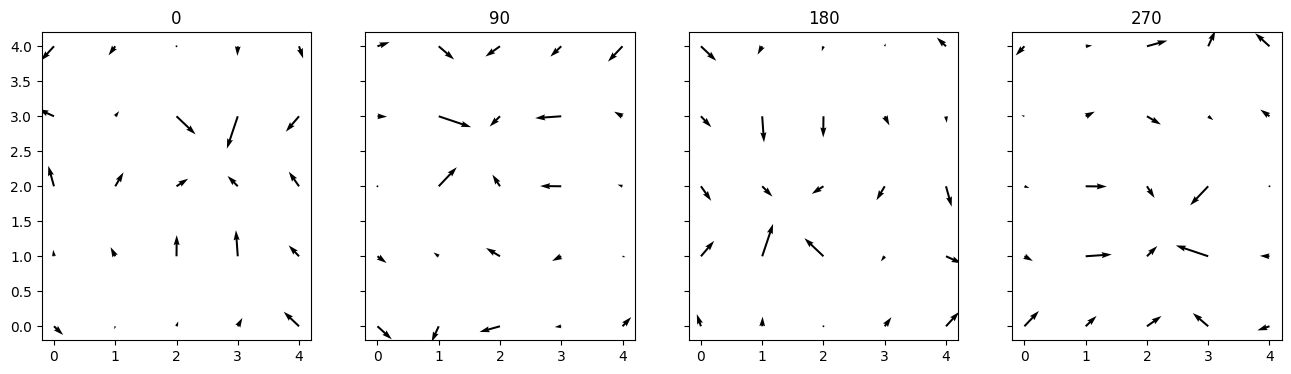

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feat_type_in = nn.FieldType(r2_act, [r2_act.trivial_repr])
feat_type_hid = nn.FieldType(r2_act, 8*[r2_act.regular_repr])

model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
).eval()

S = 11
x = torch.randn(1, 1, S, S)
x = feat_type_in(x)

fig, axs = plt.subplots(1, r2_act.fibergroup.order(), sharex=True, sharey=True, figsize=(16, 4))

X, Y = np.meshgrid(range(S-6), range(S-7, -1, -1))

# for each group element
for i, g in enumerate(r2_act.testing_elements):
    # transform the input
    x_transformed = x.transform(g)
    
    y = model(x_transformed)
    y = y.tensor.detach().numpy().squeeze()
    
    # plot the output vector field
    axs[i].quiver(X, Y, y[0, ...], y[1, ...], units='xy')
    axs[i].set_title(g.to('int')*90)
    
plt.show()


We want to mention that vector fields can not be acted on by ReLU nonlinearities since this mapping would not be equivariant.
To see this, consider a vector $(1,0)^T$ which under a rotation by $\pi$ transforms to $(-1,0)^T$.
Acting on the former by a ReLU returns the vector itself while the latter will be projected to the origin such that all information of the feature is lost.

As an alternative, we can apply nonlinearities which solely act on the *norm* of the vector but not on its orientation.
Since the vectors rotate under the action of $C_4$, both operations commute which means that such
[NormNonLinearities](https://quva-lab.github.io/escnn/api/escnn.nn.html#normnonlinearity)
are equivariant for this field type.
For instance, we can apply so called *norm-ReLUs*:

In [ ]:
norm_relu = nn.NormNonLinearity(feat_type_out, 'n_relu')

y = norm_relu(model(x))

for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = norm_relu(model(x_transformed))
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g

## Mixed Feature Fields

Our implementation allows for different feature field types in a feature space.
To achieve this, one simply has to pass a list of different representations when instantiating the `FieldType`.
As an example, let's build a feature field with 2 scalar fields, 2 regular fields and 1 vector field:

In [ ]:
feat_type_out = nn.FieldType(r2_act, 2*[r2_act.trivial_repr] + 2*[r2_act.regular_repr] + 1*[r2_act.irrep(1)])

or equivalently

In [ ]:
scalar_fields = nn.FieldType(r2_act, 2*[r2_act.trivial_repr])
regular_fields = nn.FieldType(r2_act, 2*[r2_act.regular_repr])
vector_field = nn.FieldType(r2_act, 1*[r2_act.irrep(1)])
feat_type_out = scalar_fields + regular_fields + vector_field

While the convolution layers can deal with mixed field types automatically, some additional care is needed when we apply non-linearities to mixed field types since these might not all allow for the same nonlinearity.

In the example above, we can apply ReLUs to the scalar and regular fields but we need to apply e.g. Norm-ReLUs to the vector field.
This can be achieved by using
[`MultipleModule`](https://quva-lab.github.io/escnn/api/escnn.nn.html#escnn.nn.MultipleModule)s
which split the input tensor into multiple branches, associating a different label to each of them.
Each branch is then being acted on by its own module, here an `nn.ReLU` for the `'relu'` branch and an `nn.NormNonLinearity` for the `'norm'` branch.
The output of the module is merged back together automatically.

In [ ]:
relu = nn.ReLU(scalar_fields + regular_fields)
norm_relu = nn.NormNonLinearity(vector_field)

nonlinearity = nn.MultipleModule(
                    feat_type_out,
                    ['relu']*len(scalar_fields+regular_fields) + ['norm']*len(vector_field),
                    [(relu, 'relu'), (norm_relu, 'norm')]
)

We once again verify that this operation is $C_4$-equivariant:

In [ ]:
model = nn.SequentialModule(
    nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=3),
    nn.InnerBatchNorm(feat_type_hid),
    nn.ReLU(feat_type_hid),
    nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=3),
    nonlinearity,
).eval()

x = torch.randn(1, 1, 17, 17)
x = feat_type_in(x)

y = model(x)

for g in r2_act.testing_elements:
    x_transformed = x.transform(g)
    y_from_x_transformed = model(x_transformed)
    
    y_transformed_from_x = y.transform(g)
    
    assert torch.allclose(y_from_x_transformed.tensor, y_transformed_from_x.tensor, atol=1e-5), g